# Trump Tweets

This the data behind the story [The World’s Favorite Donald Trump Tweets](https://fivethirtyeight.com/features/the-worlds-favorite-donald-trump-tweets/).

In [55]:
# The usual suspects ...
import warnings
warnings.filterwarnings('ignore')

import logging
import string
import re
import pyLDAvis.gensim
import pandas_profiling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time_series as ts

# And their accomplices ...
from scipy import stats
from matplotlib.ticker import FuncFormatter
from textblob import TextBlob
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from collections import Counter
from pprint import pprint

# Settings
sns.set_style('white')
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [56]:
# Getting the data
df = pd.read_csv('data/realDonaldTrump_poll_tweets.csv')

In [57]:
# Size
df.shape

(448, 3)

In [58]:
# Top rows
df.head()

,id,created_at,text
0,7.656299e+17,8/16/2016 19:22:57,"It's just a 2-point race, Clinton 38%, Trump 3..."
1,7.587319e+17,7/28/2016 18:32:31,"""@LallyRay: Poll: Donald Trump Sees 17-Point P..."
2,7.583505e+17,7/27/2016 17:16:56,Great new poll - thank you!\n#MakeAmericaGreat...
3,7.575775e+17,7/25/2016 14:05:27,Great POLL numbers are coming out all over. Pe...
4,7.536034e+17,7/14/2016 14:53:46,Another new poll. Thank you for your support! ...


#### Preprocessing

In [59]:
# Datetime
ts.convert_to_datetime(data=df, column='created_at')

In [60]:
# Removing @user references and links
def strip_links(text):
    '''Removes links in text.'''
    link_regex = re.compile(r'((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

def strip_all_entities(text):
    '''Removes @user references and hashtags.'''
    entity_prefixes = ['@', '#']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator, '')
    words = list()
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [61]:
for i in range(len(df)):
    df.loc[i, 'text'] = strip_all_entities(strip_links(df.loc[i, 'text']))

df['text'].head(10)

0           Its just a 2point race Clinton 38 Trump 36
1    Poll Donald Trump Sees 17Point Positive Swing ...
2                             Great new poll thank you
3    Great POLL numbers are coming out all over Peo...
4    Another new poll Thank you for your support Jo...
5                     Great new poll thank you America
6    Despite spending 500k a day on TV ads alone fa...
7                         Great poll Florida Thank you
8                                   New poll thank you
9    New Q poll out we are going to win the whole d...
Name: text, dtype: object

In [62]:
# Emoticons and emojis
# HappyEmoticons
emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
                       ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
                       '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
                       'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
                       '<3'])

# Sad Emoticons
emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
                     ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
                     ':c', ':{', '>:\\', ';('])

# Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

# Combine
emoticons = emoticons_happy.union(emoticons_sad)

In [63]:
# Text corpus
document = [i for i in df['text']]

# Removing common words and tokenize
stop_words = set(stopwords.words('english'))
stop_words.update(['-', '=', '+', '*','.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',
                   'amp', 'kkk', 'hahaha', 'haha', 'ha'])
for doc in document:
    list_of_words = [i.lower() for i in wordpunct_tokenize(doc) if i.lower() not in stop_words]
stop_words.update(list_of_words)

# Removing common words
texts = [[word for word in doc.lower().split() if word not in stop_words] for doc in document]

# Removing words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

# Removing empty tokens
texts = [text for text in texts if len(text) > 1]

# Removing emojis
texts = [[token for token in text if token not in emoticons] for text in texts]

# Printing the top 10
#pprint(texts[:10])

#### Transformation: Document dictionary

In [64]:
# Create dictionary of document
bag = corpora.Dictionary(texts)
bag.save('models/trump.dict')

# Converting document to a vector (bag-of-words)
corpus = [bag.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('models/trump.mm', corpus)

We have assigned a unique integer id to all words appearing in the corpus by:
   
   1. sweeping across the texts
   2. collecting word counts and relevant statistics
   
Our corpus is a 448 x 661 matrix.

***

#### Transformation: _tf-idf_

#### Step 1:

In [65]:
# Initialization
tfidf = models.TfidfModel(corpus)

We have initialized (trained) a transaformation model. Different transformation may require different initialization parameters; however, in our case, ___tf-idf___, the "training" consists simply of going through the supplied corpus once and computing document frequencies of all its features. This is in comparison to ___Latent Semantic Analysis___ & ___Latent Dirichlet Allocation___ which are more involved and take more time.

**A note on transaformations**:
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where ___tf-idf___ vectors are expceted, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

#### Step 2:
From now on, ___tf-idf___ is treated as a read-only object that can be used to convert any vector from the old representation (___bag-of-words___ integer counts) to the new representation (___tf-idf___ real-valued weights).

In [66]:
# Applying the transformation to the whole corpus
corpus_tfidf = tfidf[corpus]

We have transformed our corpus (the one we used for training) into a weighted vector. We can do this for any vector (provided they come from the same vector space), even if they are not used in the corpus at all. This can be achived by _folding-in_ for ___LSA___ and by _topic inference_ for ___LDA___.

#### Step 3:
We will transform our ___tf-idf___ corpus via [Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_indexing) into a latent 10-D space (... num_topics = 10).

In [67]:
# Initializing an LSI transformation
lsi = models.LsiModel(corpus_tfidf, id2word=bag, num_topics=5)
corpus_lsi = lsi[corpus_tfidf]

In [68]:
lsi.print_topics()

[(0,
  '0.587*"thank" + 0.417*"new" + 0.410*"great" + 0.209*"poll" + 0.156*"america" + 0.148*"numbers" + 0.132*"iowa" + 0.116*"reuters" + 0.106*"trump" + 0.102*"support"'),
 (1,
  '0.444*"thank" + -0.339*"trump" + -0.215*"donald" + -0.199*"lead" + -0.196*"carson" + -0.191*"leads" + -0.188*"rubio" + -0.173*"national" + -0.172*"cruz" + -0.146*"debate"'),
 (2,
  '0.396*"great" + -0.273*"thank" + 0.233*"big" + 0.228*"numbers" + 0.201*"america" + -0.200*"carson" + 0.187*"make" + 0.179*"debate" + -0.171*"rubio" + 0.154*"good"'),
 (3,
  '0.422*"great" + -0.382*"national" + 0.318*"leads" + -0.265*"iowa" + -0.214*"lead" + 0.195*"rubio" + -0.170*"released" + 0.167*"trump" + 0.156*"carson" + -0.150*"debate"'),
 (4,
  '0.415*"debate" + -0.327*"national" + 0.256*"thank" + 0.250*"said" + -0.206*"new" + -0.183*"leads" + -0.162*"america" + 0.142*"carson" + 0.137*"every" + -0.135*"great"')]

#### Topics

According to ___LSI___:
<br>
**Topic 1**
> References poll numbers, Iowa, Reuters and Trump.

**Topic 2**
> References Trump, Carson, Rubio, and Cruz. This may Trump making comparisons with his competition.

**Topic 3**
> References debate, Carson, and Rubio hinting at what these individuals may have said in the debate.

**Topic 4**
> References great, debate, big, and leads. This may be Trump talking about the debate and the favorable outcome.

**Topic 5**
> References similar words as topic 4.

In [69]:
# Model persistence: save(), load()
lsi.save('models/trump.lsi')
lsi = models.LsiModel.load('models/trump.lsi')

***
### Similarity

#### Step 1:

In [70]:
# Initializing the query structure: transform corpus to LSI space and index it
index = similarities.MatrixSimilarity(lsi[corpus])

# Index persistence
index.save('models/trump.index')
index = similarities.MatrixSimilarity.load('models/trump.index')

#### Step 2:

In [71]:
def query_similarity(doc, index=index):
    
    # Performing queries
    vec_bow = bag.doc2bow(doc.lower().split())

    # Convert the query to LSI space
    vec_lsi = lsi[vec_bow]

    # Perform a similarity query against the corpus
    sims = index[vec_lsi]

    # Ranking the tweets by their weights of similarity
    sims = sorted(enumerate(sims), key=lambda item: -item[1])

    # Printing the associated Tweets:
    for i in range(10):
        print("Tweet Rank #{}:\tWeight: {}\nRaw text: {}\n".format(i+1, sims[i][1], document[sims[i][0]]))

In [72]:
query_similarity(doc='Hillary Clinton', index=index)

Tweet Rank #1:	Weight: 0.983793318271637
Raw text: Hillary Clinton is not a change agent just the same old status quo She is spending a fortune I am spending very little Close in polls

Tweet Rank #2:	Weight: 0.9751976132392883
Raw text: The refused to use their just in poll numbers where I have a massive lead but instead used numbers where my lead is smaller

Tweet Rank #3:	Weight: 0.9703873991966248
Raw text: Sickening attempt I hope jumps another 10 points

Tweet Rank #4:	Weight: 0.9700741767883301
Raw text: CNBC poll Trump won

Tweet Rank #5:	Weight: 0.9652115106582642
Raw text: Ted Cruz didnt win Iowa he stole it That is why all of the polls were so wrong and why he got far more votes than anticipated Bad

Tweet Rank #6:	Weight: 0.9574382901191711
Raw text: Watch my interview on Face The Nation now and also the new CBS POLLS which if good for me the media wont report

Tweet Rank #7:	Weight: 0.9384174346923828
Raw text: RT Today we spoke with Donald Trump about his rising leads in 

When we make a query for "Hillary Clinton" to retrieve the respective top tweets associated with her name, we find that the leading tweet with the greatest weight is a strong criticism of Hillary Clinton and her campaign spending. The remaining nine tweets are associated with the polls, darted with references to Donald Trump criticizing poll results not in his favor, him leading against the opposition as well as pitting himself likely to win.

In [73]:
# Performing queries
query_similarity(doc="Ben Carson")

Tweet Rank #1:	Weight: 0.9979457259178162
Raw text: All seven online polls including Drudge and Time with thousands of respondents said I won the debate said I was so so

Tweet Rank #2:	Weight: 0.9926984906196594
Raw text: Morning Consult poll Trump Leads

Tweet Rank #3:	Weight: 0.991386353969574
Raw text: RT New poll finds lean Republicans think most likely to be GOP nominee and has best cha…

Tweet Rank #4:	Weight: 0.9866174459457397
Raw text: New CNNORC poll w 24 favorability rating on the rise while Jebs declines 60 among women

Tweet Rank #5:	Weight: 0.9771937727928162
Raw text: Rasmussen now beats 3836 nationally

Tweet Rank #6:	Weight: 0.975827157497406
Raw text: WSJNBC Poll Donald Trump Widens His Lead in Republican Presidential Race

Tweet Rank #7:	Weight: 0.9689033031463623
Raw text: GREAT Video Which of these 4 Polls is Suspect Kudos to

Tweet Rank #8:	Weight: 0.9680923223495483
Raw text: We are getting reports from many voters that the Cruz people are back to doing very sle

#### Transformation: LDA

In [74]:
# LDA Transformation
lda = models.LdaModel(corpus_tfidf, id2word=bag, num_topics=5)
corpus_lda = lda[corpus_tfidf]

In [75]:
lda.print_topics()

[(0,
  '0.011*"trump" + 0.010*"new" + 0.010*"great" + 0.009*"numbers" + 0.008*"poll" + 0.007*"race" + 0.007*"support" + 0.007*"winning" + 0.006*"one" + 0.006*"clinton"'),
 (1,
  '0.037*"thank" + 0.024*"great" + 0.021*"new" + 0.014*"poll" + 0.013*"iowa" + 0.009*"via" + 0.008*"numbers" + 0.008*"cbs" + 0.007*"trump" + 0.007*"news"'),
 (2,
  '0.012*"new" + 0.012*"trump" + 0.010*"said" + 0.009*"another" + 0.009*"debate" + 0.008*"poll" + 0.008*"leads" + 0.007*"donald" + 0.007*"win" + 0.006*"lead"'),
 (3,
  '0.012*"leads" + 0.012*"national" + 0.011*"trump" + 0.011*"new" + 0.010*"lead" + 0.010*"poll" + 0.009*"thank" + 0.008*"carson" + 0.008*"big" + 0.008*"even"'),
 (4,
  '0.013*"thank" + 0.013*"new" + 0.011*"reuters" + 0.011*"trump" + 0.010*"great" + 0.010*"cruz" + 0.010*"america" + 0.009*"poll" + 0.009*"rubio" + 0.008*"numbers"')]

In [76]:
# Visualizing LDA topic models
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.064503 -0.019221       1        1  23.641579
3     -0.019799  0.040811       2        1  23.224768
1      0.027977 -0.061680       3        1  18.850571
2      0.015065  0.013751       4        1  17.913876
0      0.041261  0.026338       5        1  16.369211, topic_info=    Category       Freq          Term      Total  loglift  logprob
11   Default  48.000000         thank  48.000000  30.0000  30.0000
7    Default  41.000000         great  41.000000  29.0000  29.0000
61   Default  19.000000         leads  19.000000  28.0000  28.0000
143  Default  11.000000          said  11.000000  27.0000  27.0000
102  Default  17.000000       reuters  17.000000  26.0000  26.0000
78   Default   9.000000           cbs   9.000000  25.0000  25.0000
12   Default  12.000000       another  12.000000  24.0000  24.0000
211  Default   7.000000        nevada   7.000000  23.0000  23.0000
367  Default   5.000000     according   5.000000  22.0000  22.0000
308  Default   7.000000         beats   7.000000  21.0000  21.0000
3    Default  10.000000          race  10.000000  20.0000  20.0000
124  Default   8.000000  presidential   8.000000  19.0000  19.0000
150  Default   7.000000          head   7.000000  18.0000  18.0000
356  Default   5.000000        sunday   5.000000  17.0000  17.0000
524  Default   6.000000     bloomberg   6.000000  16.0000  16.0000
170  Default  14.000000           via  14.000000  15.0000  15.0000
197  Default  24.000000      national  24.000000  14.0000  14.0000
460  Default   7.000000        gravis   7.000000  13.0000  13.0000
245  Default  24.000000          iowa  24.000000  12.0000  12.0000
148  Default   5.000000         texas   5.000000  11.0000  11.0000
125  Default   7.000000             1   7.000000  10.0000  10.0000
256  Default   8.000000         finds   8.000000   9.0000   9.0000
300  Default   8.000000            39   8.000000   8.0000   8.0000
361  Default  11.000000         first  11.000000   7.0000   7.0000
477  Default   8.000000       percent   8.000000   6.0000   6.0000
279  Default  10.000000           fox  10.000000   5.0000   5.0000
380  Default   7.000000    nationally   7.000000   4.0000   4.0000
304  Default   5.000000            us   5.000000   3.0000   3.0000
436  Default   4.000000         video   4.000000   2.0000   2.0000
37   Default  14.000000           win  14.000000   1.0000   1.0000
..       ...        ...           ...        ...      ...      ...
289   Topic5   2.380820           low   5.646139   0.9462  -5.5187
417   Topic5   2.433500          high   5.801620   0.9410  -5.4968
116   Topic5   1.800383            sc   4.337681   0.9304  -5.7981
164   Topic5   2.482265       beating   6.031765   0.9219  -5.4769
455   Topic5   2.119372          cnbc   5.265795   0.8997  -5.6350
3     Topic5   4.055293          race  10.293528   0.8783  -4.9861
291   Topic5   3.408611           use   8.810350   0.8601  -5.1598
150   Topic5   2.754654          head   7.124509   0.8595  -5.3728
115   Topic5   3.832942           one  11.327479   0.7262  -5.0425
147   Topic5   3.863048       winning  11.888435   0.6857  -5.0347
2     Topic5   3.814971       clinton  11.719259   0.6875  -5.0472
211   Topic5   2.916511        nevada   7.951683   0.8068  -5.3157
19    Topic5   5.438976       numbers  23.066483   0.3650  -4.6925
4     Topic5   6.606659         trump  37.282684   0.0793  -4.4980
18    Topic5   3.805882       hillary  14.630708   0.4632  -5.0496
24    Topic5   3.873158       support  15.566481   0.4187  -5.0320
169   Topic5   2.840163             9   8.466525   0.7175  -5.3423
7     Topic5   5.647810         great  41.207645  -0.1776  -4.6548
10    Topic5   5.724596           new  47.804176  -0.3126  -4.6413
52    Topic5   2.891401           far   9.489221   0.6214  -5.3244
8     Topic5   4.677227          poll  35.721214  -0.2233  -4.8434
154   Topic5   3.270271     

#### Dominant topics and percentage contribution

In [77]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    '''Returns dominant topics and respective percentage contributions with original text.'''
    # Initialize output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic for each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_distribution', 'topic_keywords']
    
    # Add original text to the end of output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [78]:
df_topic_sent_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

In [79]:
# Formatting
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
df_dominant_topic.head(10)

,document_number,dominant_topic,topic_percentage_contribution,keywords,text
0,0,0.0,0.8651,"trump, new, great, numbers, poll, race, suppor...","[race, clinton, 38, trump, 36]"
1,1,4.0,0.8832,"thank, new, reuters, trump, great, cruz, ameri...","[poll, donald, trump, two, breitbart, great]"
2,2,1.0,0.8382,"thank, great, new, poll, iowa, via, numbers, c...","[great, new, poll, thank]"
3,3,2.0,0.9451,"new, trump, said, another, debate, poll, leads...","[great, poll, numbers, coming, people, dont, w..."
4,4,1.0,0.5258,"thank, great, new, poll, iowa, via, numbers, c...","[another, new, poll, thank, support]"
5,5,1.0,0.8641,"thank, great, new, poll, iowa, via, numbers, c...","[great, new, poll, thank, america]"
6,6,3.0,0.7775,"leads, national, trump, new, lead, poll, thank...","[despite, spending, day, ads, nationwide, zero..."
7,7,1.0,0.4863,"thank, great, new, poll, iowa, via, numbers, c...","[great, poll, florida, thank]"
8,8,1.0,0.7974,"thank, great, new, poll, iowa, via, numbers, c...","[new, poll, thank]"
9,9,4.0,0.9093,"thank, new, reuters, trump, great, cruz, ameri...","[new, q, poll, going, win, make, america, great]"


#### Most representative sentence for each topic

In [80]:
# Formatting
sent_topic_sorted_df_mallet = pd.DataFrame()
sent_topic_out_df_grouped = df_topic_sent_keywords.groupby('dominant_topic')

for item, group in sent_topic_out_df_grouped:
    sent_topic_sorted_df_mallet = pd.concat([sent_topic_sorted_df_mallet,
                                             group.sort_values(['percentage_distribution'],
                                                               ascending=False).head(1)],
                                            axis=0)
    
# Reset index
sent_topic_sorted_df_mallet.reset_index(drop=True, inplace=True)

# Formatting
sent_topic_sorted_df_mallet.columns = ['topic_number', 'topic_percentage_contribution', 'keywords', 'representative_text']

# Display
sent_topic_sorted_df_mallet.head(10)

,topic_number,topic_percentage_contribution,keywords,representative_text
0,0.0,0.9456,"trump, new, great, numbers, poll, race, suppor...","[respected, morning, consult, poll, lead, repu..."
1,1.0,0.9372,"thank, great, new, poll, iowa, via, numbers, c...","[leading, bloomberg, iowa, poll, also, favorab..."
2,2.0,0.9607,"new, trump, said, another, debate, poll, leads...","[latest, umass, tracking, poll, nh, trump, 35,..."
3,3.0,0.9624,"leads, national, trump, new, lead, poll, thank...","[2016, republican, primary, morning, consult, ..."
4,4.0,0.9571,"thank, new, reuters, trump, great, cruz, ameri...","[new, hampshire, poll, race, new, hampshire, t..."


#### Frequency distribution of word counts in documents

Text(0.5, 1.0, 'Distribution of Document Word Counts')

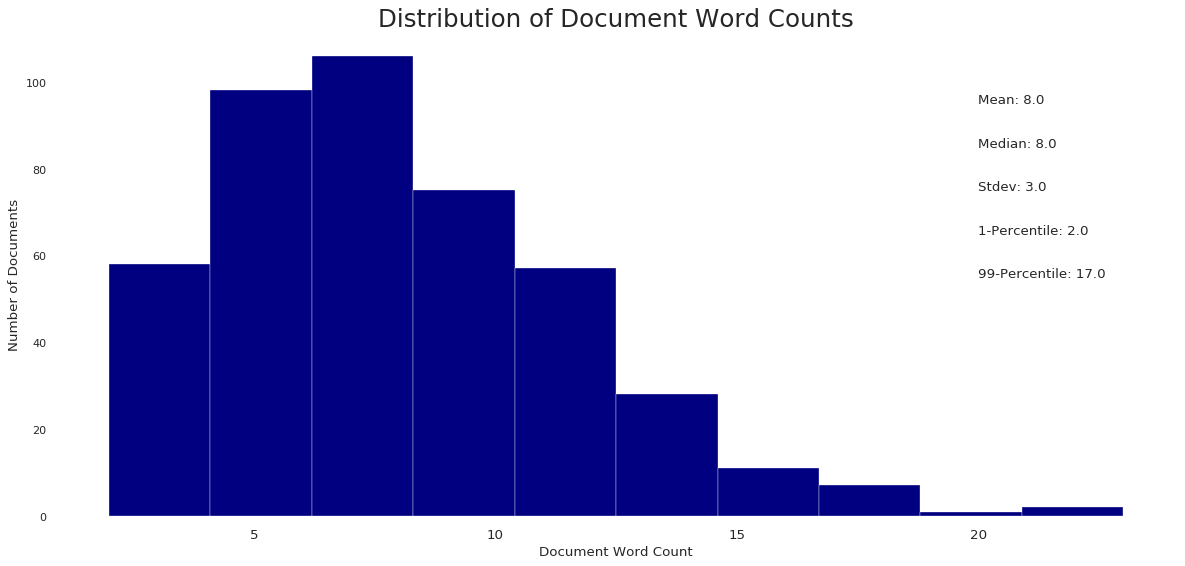

In [81]:
# Document length
doc_length = [len(d) for d in df_dominant_topic['text']]

# Plotting
plt.figure(figsize=(18, 8), dpi=80)
plt.hist(doc_length, bins=10, color='navy')
plt.text(20, 95, 'Mean: ' + str(round(np.mean(doc_length))), fontsize=12)
plt.text(20, 85, 'Median: ' + str(round(np.median(doc_length))), fontsize=12)
plt.text(20, 75, 'Stdev: ' + str(round(np.std(doc_length))), fontsize=12)
plt.text(20, 65, '1-Percentile: ' + str(round(np.quantile(doc_length, q=0.01))), fontsize=12)
plt.text(20, 55, '99-Percentile: ' + str(round(np.quantile(doc_length, q=0.99))), fontsize=12)
plt.xticks(size=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xlabel('Document Word Count', fontsize=12)
plt.title('Distribution of Document Word Counts', fontsize=22)

#### Word counts of topic keywords

In [82]:
# Formatting
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = list()
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])
data = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

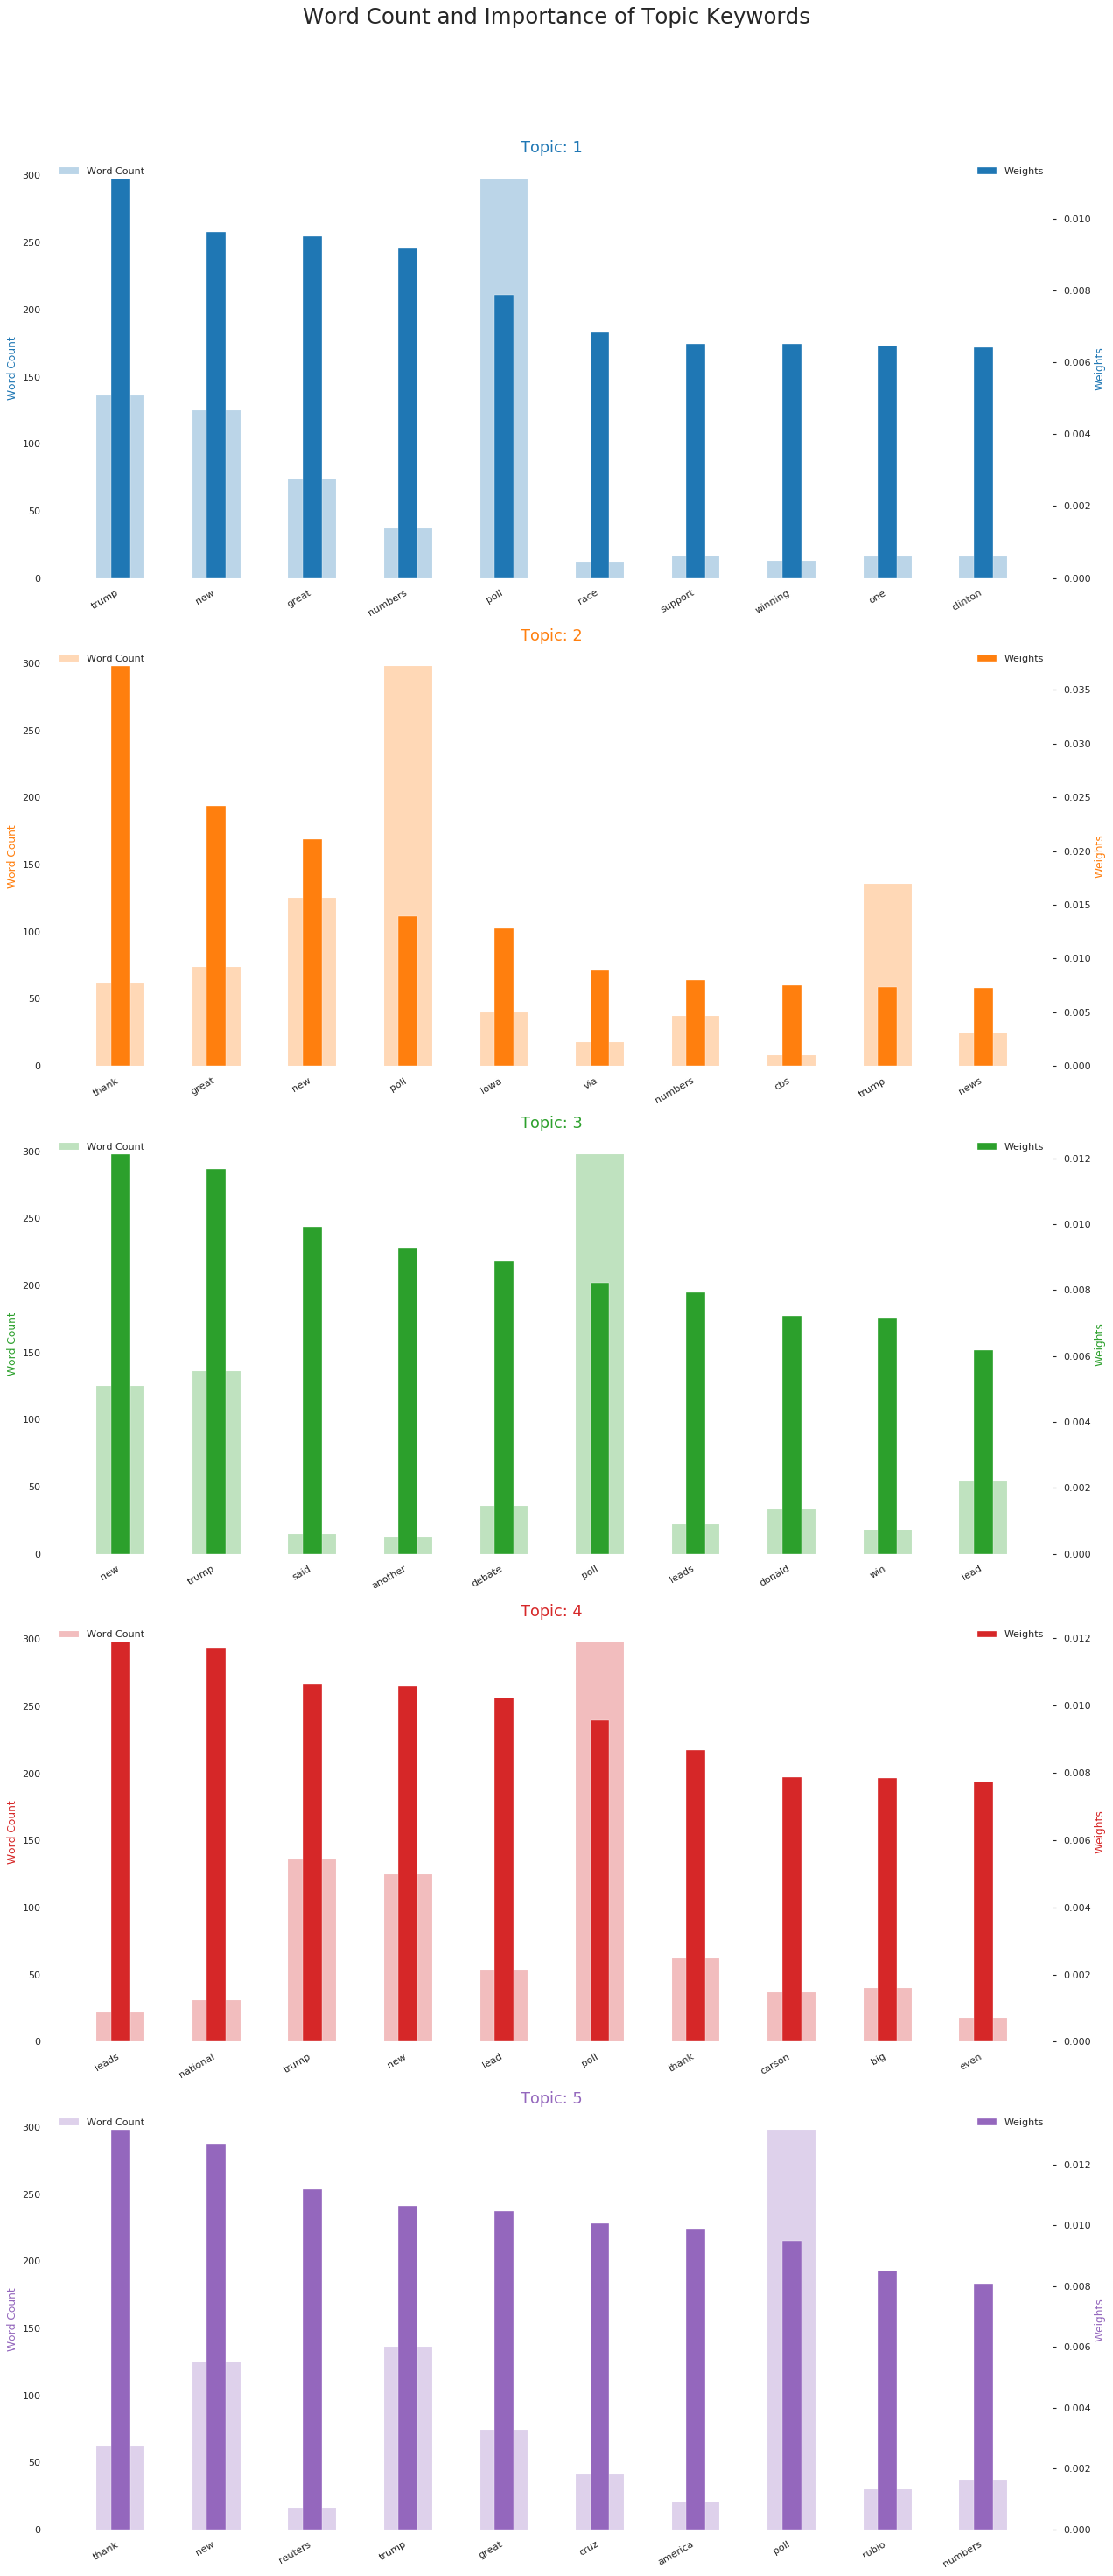

In [83]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(16, 35), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height='word_count', data=data.loc[data.topic_id == i, :], color=cols[i], width=.5, alpha=.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height='importance', data=data.loc[data.topic_id == i, :], color=cols[i], width=.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylabel('Weights', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(data.loc[data.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

#### What are the most discussed topics in the tweets?

In [84]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics, topic_percentages = list(), list()
    for i, corp in enumerate(corpus_sel):
        topic_id_percentages = lda[corp]
        dominant_topic = sorted(topic_id_percentages, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_id_percentages)
    return dominant_topics, topic_percentages

dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpus, end=-1)

In [85]:
# Distribution of dominant topics in each document
df_2 = pd.DataFrame(dominant_topics, columns=['document_id', 'dominant_topic'])
dominant_topic_in_each_document = df_2.groupby('dominant_topic').size()
df_dominant_topic_in_each_document = dominant_topic_in_each_document.to_frame(name='count').reset_index()

In [86]:
# Total topic distribution by actual weight
topic_weightage_by_document = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_document.sum().to_frame(name='count').reset_index()

In [87]:
# Top 3 keywords for each topic
topic_top_3_words =  [(i, topic) for i, topics in lda.show_topics(formatted=False) for j, (topic, wt) in enumerate(topics) if j < 3]
df_top_3_words_stacked = pd.DataFrame(topic_top_3_words, columns=['topic_id', 'words'])
df_top_3_words = df_top_3_words_stacked.groupby('topic_id').agg(', \n'.join)
df_top_3_words.reset_index(level=0, inplace=True)

We will now make two plots:

>1. the number of documents for each topic by assigning the document to the topic that has the most weight in that document.
>2. the number of documents for each topic by summing up the actual weight contribution of each topic to respective documents.

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

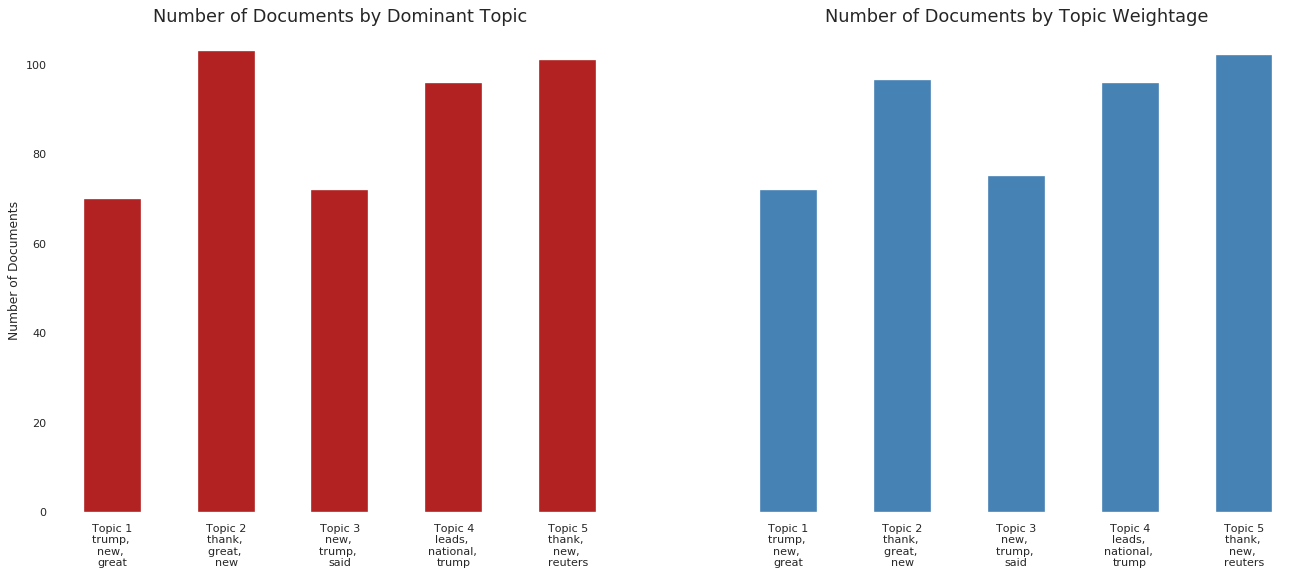

In [88]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)

# Topic distribution by dominant topics
ax1.bar(x='dominant_topic', height='count', data=df_dominant_topic_in_each_document, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_document.dominant_topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1) + '\n' + df_top_3_words.loc[df_top_3_words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents')

# Topic distribution by topic weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=16))

#### Polarity and subjectivity of sentiments

In [89]:
# Create polarity and subjectivity columns
def polarity_and_subjectivity(df, column):
    '''Creates the polarity and subjectivity columns.'''
    polarity, subjectivity = list(), list()
    for tweet in df[column]:
        blob = TextBlob(tweet)
        polarity.append(blob.polarity)
        subjectivity.append(blob.subjectivity)
    df['polarity'] = polarity
    df['subjectivity'] = subjectivity

polarity_and_subjectivity(df=df, column='text')

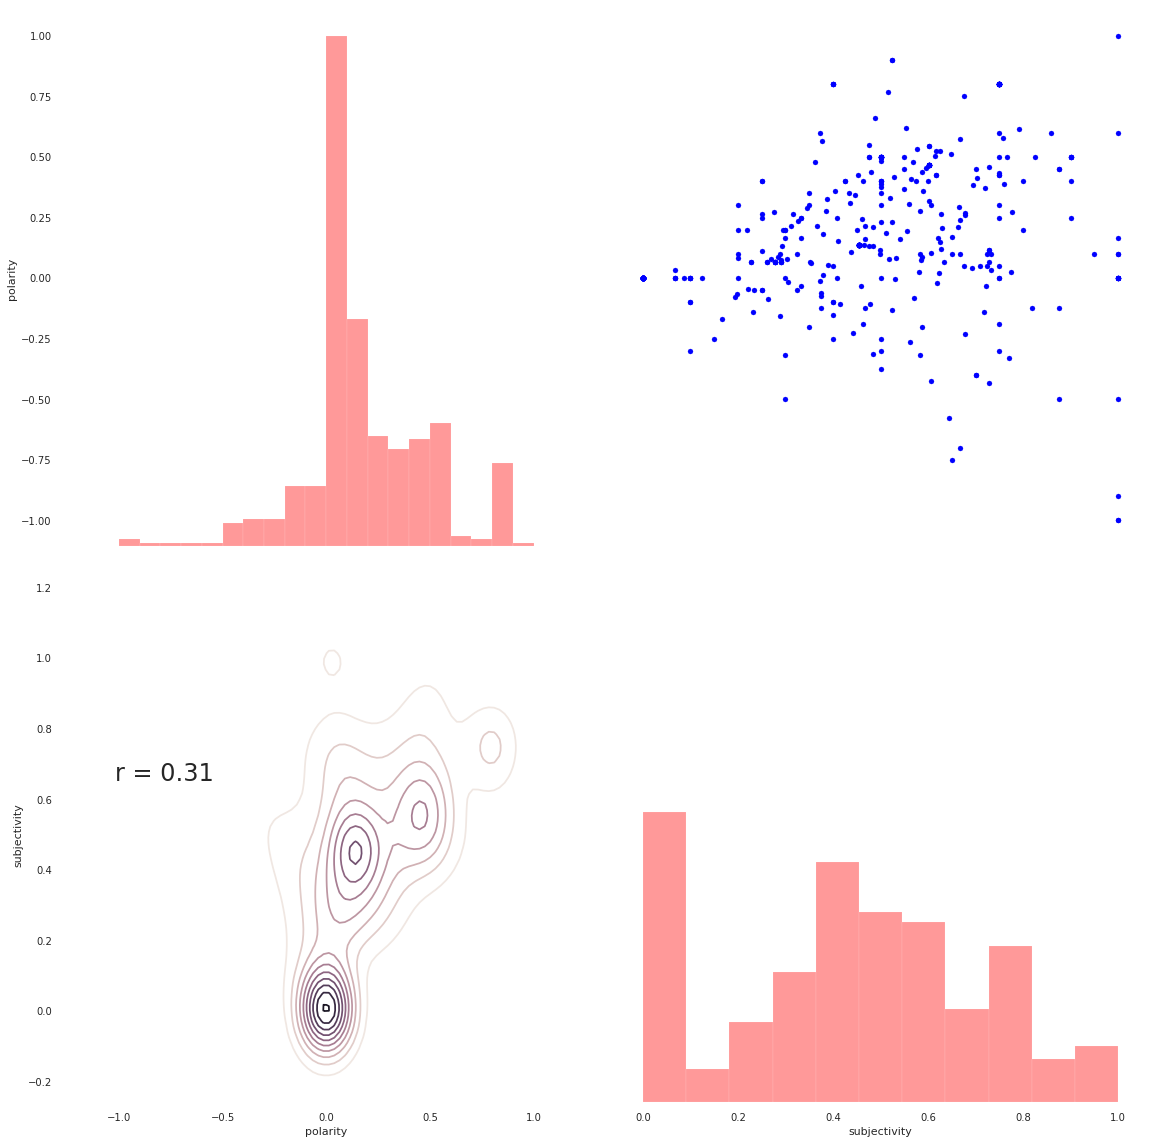

In [90]:
# Correlations
def correlations(x, y, **kws):
    '''Calculate correlation coefficients.'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6),
                xycoords=ax.transAxes,
                size=24)

cmap = sns.cubehelix_palette(light=1, dark=.01, hue=.5, as_cmap=True)
sns.set_context(font_scale=2)

# Pairgrid setup
g = sns.PairGrid(df.drop('id', axis=1), height=8)
# Scatterplot on upper triangle
g.map_upper(plt.scatter, s=25, color='blue')
# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color='red')
# Densityplot and correlation coefficients on lower triangle
g.map_lower(sns.kdeplot, cmap=cmap)
g.map_lower(correlations)

(None, None)

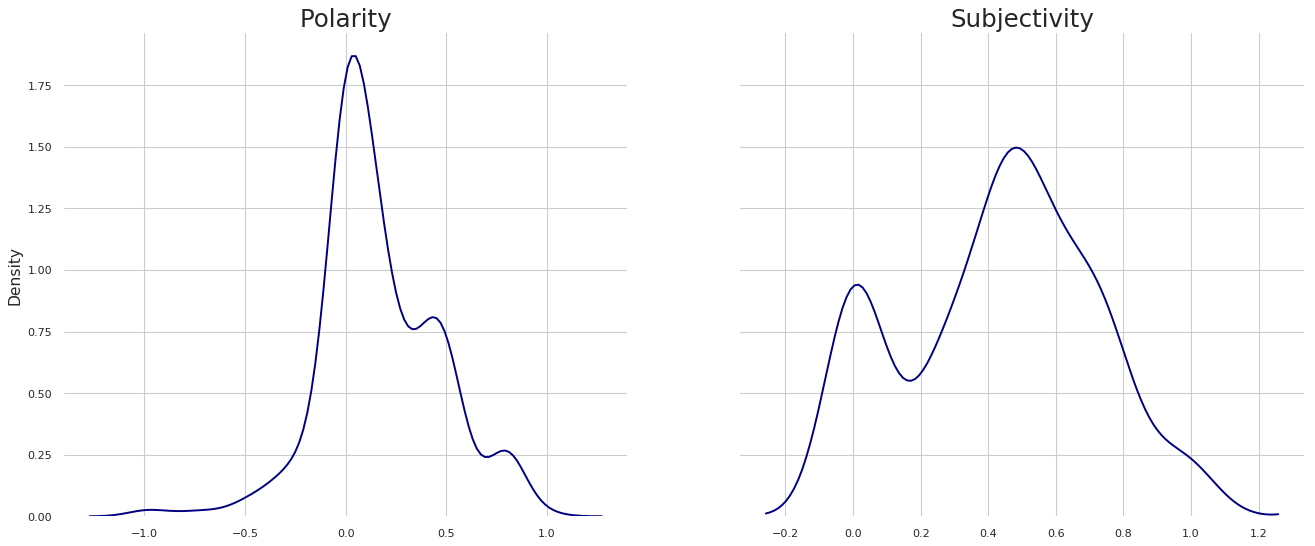

In [91]:
# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)
sns.distplot(df['polarity'], ax=ax1, color='navy', hist=False)
sns.distplot(df['subjectivity'], ax=ax2, color='navy', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

#### Comparison: Polarity and subjectivity

(None, None)

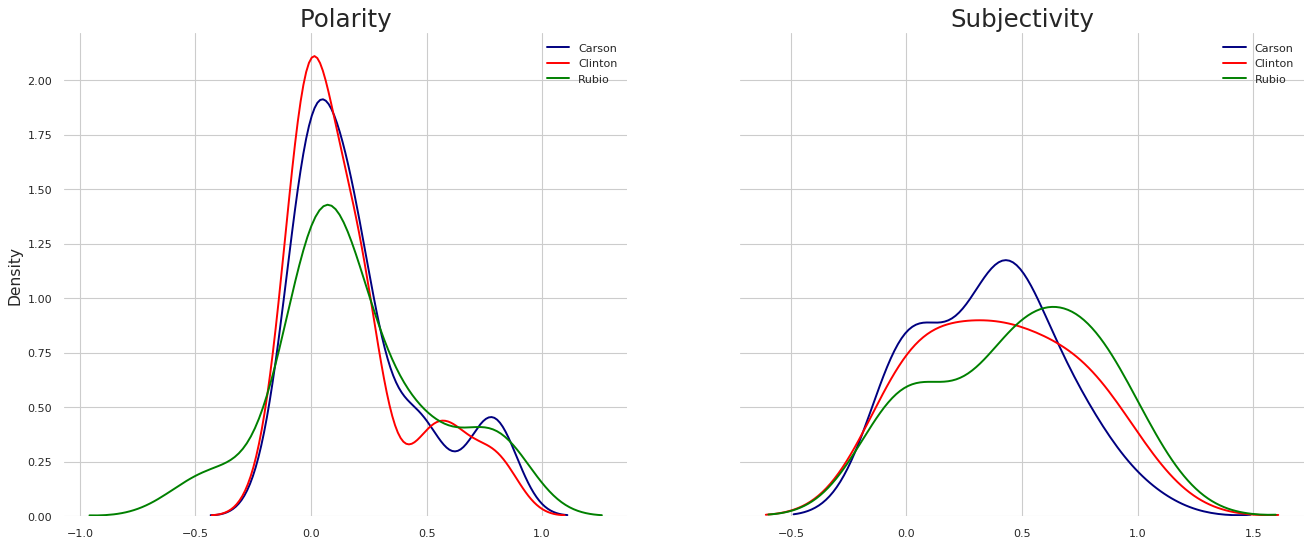

In [92]:
# Comparing subjectivity and polarity between candidates
carson = df.loc[df['text'].str.contains('Carson')]
clinton = df.loc[df['text'].str.contains('Clinton')]
rubio = df.loc[df['text'].str.contains('Rubio')]

# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)
sns.distplot(carson['polarity'], label='Carson', ax=ax1, color='navy', hist=False)
sns.distplot(clinton['polarity'], label='Clinton', ax=ax1, color='red', hist=False)
sns.distplot(rubio['polarity'], label='Rubio', ax=ax1, color='green', hist=False)
sns.distplot(carson['subjectivity'], label='Carson', ax=ax2, color='navy', hist=False)
sns.distplot(clinton['subjectivity'], label='Clinton', ax=ax2, color='red', hist=False)
sns.distplot(rubio['subjectivity'], label='Rubio', ax=ax2, color='green', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

#### Comparison: Time series of polarity and subjectivity

In [93]:
# Creating time series objects
# Polarity
carson_polarity = ts.create_series(carson, 'created_at', 'polarity')
clinton_polarity = ts.create_series(clinton, 'created_at', 'polarity')
rubio_polarity = ts.create_series(rubio, 'created_at', 'polarity')

# Subjectivity
carson_subjectivity = ts.create_series(carson, 'created_at', 'subjectivity')
clinton_subjectivity = ts.create_series(clinton, 'created_at', 'subjectivity')
rubio_subjectivity = ts.create_series(rubio, 'created_at', 'subjectivity')

In [94]:
def smooth(x,window_len=11,window='hanning'):
    '''smooth the data using a window with requested size.
    
    NB: Taken from scipy cookbook.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    '''

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    return np.convolve(w/w.sum(), s, mode='valid')

(None, None)

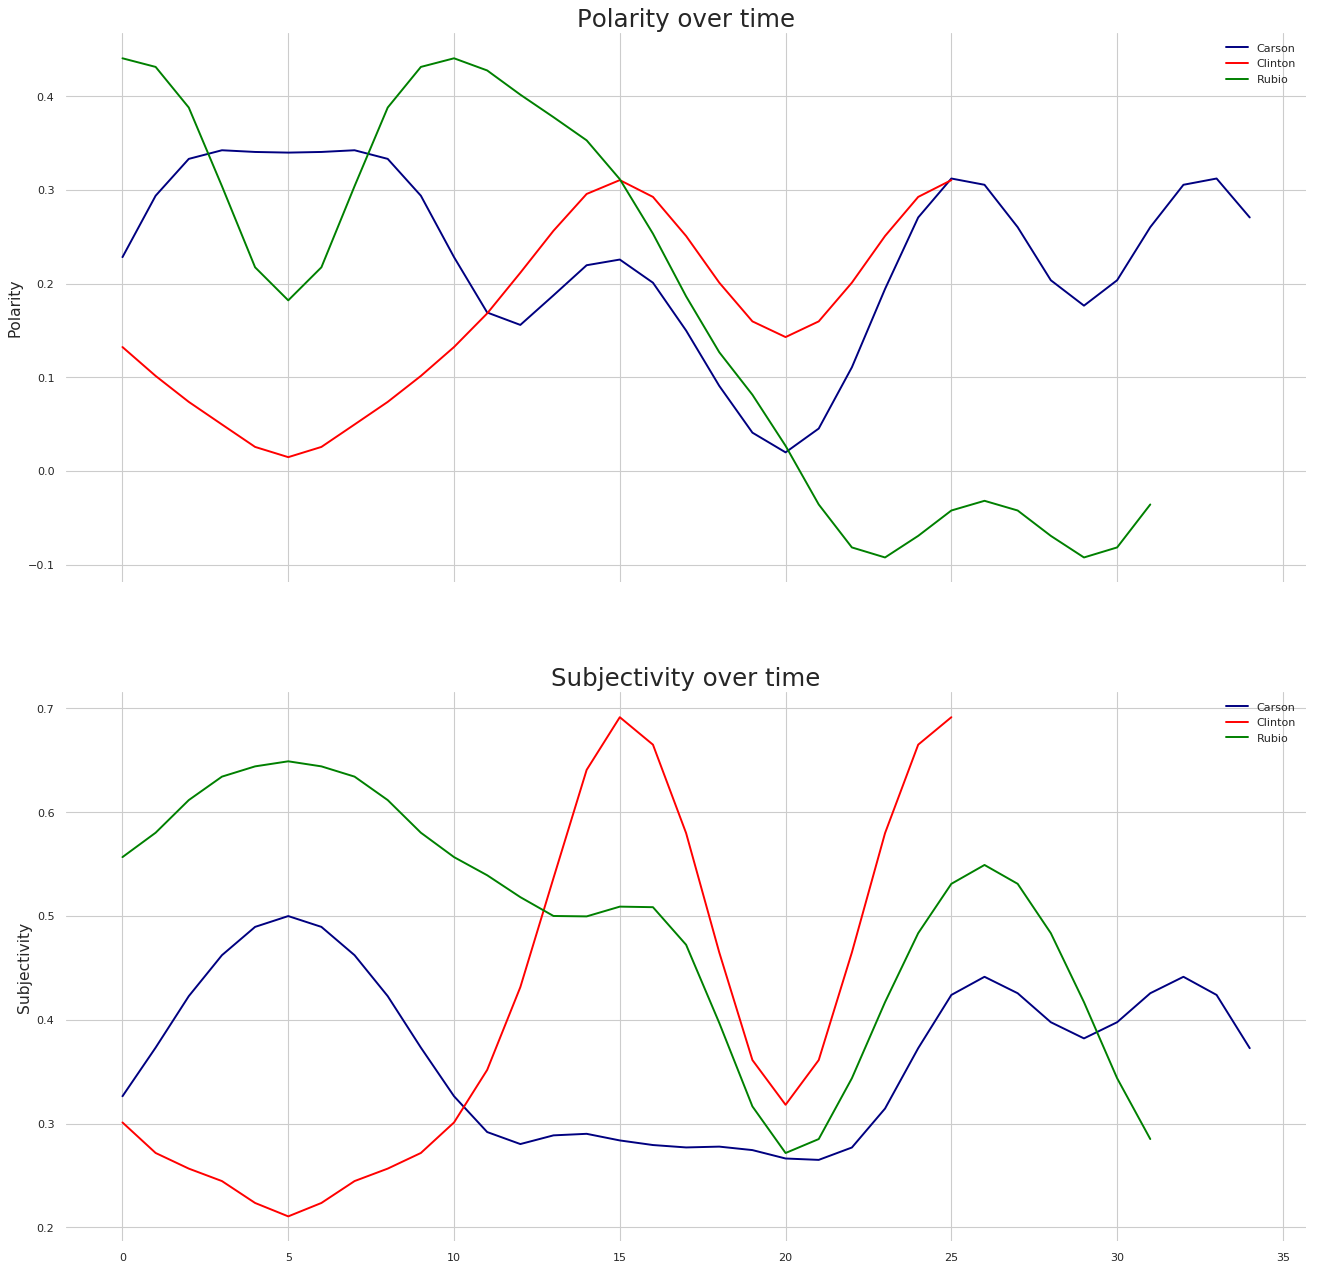

In [95]:
# Plotting polarity
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), dpi=80, sharex=True)
sns.lineplot(data=smooth(carson_polarity), label='Carson', color='navy', ax=ax1)
sns.lineplot(data=smooth(clinton_polarity), label='Clinton', color='red', ax=ax1)
sns.lineplot(data=smooth(rubio_polarity), label='Rubio', color='green', ax=ax1)
sns.lineplot(data=smooth(carson_subjectivity), label='Carson', color='navy', ax=ax2)
sns.lineplot(data=smooth(clinton_subjectivity), label='Clinton', color='red', ax=ax2)
sns.lineplot(data=smooth(rubio_subjectivity), label='Rubio', color='green', ax=ax2)
ax1.set_title('Polarity over time', fontsize=22)
ax2.set_title('Subjectivity over time', fontsize=22)
ax1.set_ylabel('Polarity', fontsize=14)
ax2.set_ylabel('Subjectivity', fontsize=14)
ax1.legend(), ax2.legend()
ax1.grid(), ax2.grid()